I had intended to write a post about speeding up our [Numpy Ising implementation](/posts/parallelizable-numpy-implementation-of-2d-ising-model), which we [found out gave reasonable numerical values](/posts/quantitative-data-analysis-of-the-2d-ising-model), though the small grids we were able to use limited the accuracy a fair bit. However, a few difficulties came up, so I thought instead (to keep writing these a habit!) I would write a little bit about using CuPy to speed up force calculations in N-body simulations. This might be a point I'll come back to later on this blog, as I have an ongoing project implementing that.

<!-- TEASER_END -->

The part of the n-body simulation we'll look at is the calculation of forces, where the force on the i-th point particle or celestial object is:

$$ F_i = \sum_j F_{ij} = G \sum_j \frac{m_i m_j}{|\vec{r_i}-\vec{r_j}|^3 } (\vec{r_i}-\vec{r_j}) $$

From this, Newton's law gives $\vec{a_i} = \vec{F_i} / m_i$. I was trying to use my own implementation of this vectorization, but I found [a neat implementation by PMende on Stack](https://stackoverflow.com/a/52562874/4417567) that's both more general and faster than what I had been doing. Let's take a look!

In [1]:
import numpy
import cupy
import numpy_html

I basically copypasted the following:

In [2]:
def accelerations(positions, masses, G = 1):
    '''
    https://stackoverflow.com/a/52562874
    
    Params:
    - positions: numpy array of size (n,3)
    - masses: numpy array of size (n,)
    '''
    xp = cupy.get_array_module(positions)
    mass_matrix = masses.reshape((1, -1, 1))*masses.reshape((-1, 1, 1))
    disps = positions.reshape((1, -1, 3)) - positions.reshape((-1, 1, 3)) # displacements
    dists = xp.linalg.norm(disps, axis=2)
    dists[dists == 0] = 1 # Avoid divide by zero warnings
    forces = G*disps*mass_matrix/xp.expand_dims(dists, 2)**3
    return forces.sum(axis=1)/masses.reshape(-1, 1)

The main change I made was adding this line:

```python
    xp = cupy.get_array_module(positions)
```

Which returns `numpy` if we pass in a `numpy.ndarray` and `cupy` if we pass in a CuPy array. This will make this function more generic for our purposes.

Let's take a look at what each of those lines does. For the illustrations, we'll take some particularly simple values:

In [3]:
N = 5
m = numpy.arange(N) + 1
r = (numpy.arange(N*3)**2).reshape((N, 3))
m

array([1, 2, 3, 4, 5])

Pretty printing of arrays, by the way, is provided by the awesome `numpy_html` package. We can now start digging! Let's first investigate the `mass_matrix`:

In [4]:
mass_matrix = m.reshape((1, -1, 1)) * m.reshape((-1, 1, 1))
mass_matrix.T

array([[[ 1,  2,  3,  4,  5],
        [ 2,  4,  6,  8, 10],
        [ 3,  6,  9, 12, 15],
        [ 4,  8, 12, 16, 20],
        [ 5, 10, 15, 20, 25]]])

This was a `(5, 5, 1)`-shaped array, but I used a `.T` transposition so that it would print more nicely, as a `(1, 5, 5)`-shaped array. This shows that the (i, j)-th entry is just $m_i m_j$ - with the shape it has, we should be able to take advantage of Numpy broadcasting in our calculation.

Let's now look at the displacements - `disps`. The line is
```python
    disps = r.reshape((1, -1, 3)) - r.reshape((-1, 1, 3))
```
but let's break it down a little bit more. `r` is

In [5]:
r

array([[  0,   1,   4],
       [  9,  16,  25],
       [ 36,  49,  64],
       [ 81, 100, 121],
       [144, 169, 196]])

while if you reshape it with a single added dimension (signified by `1`) in the first place:

In [6]:
r.reshape((1, -1, 3))

array([[[  0,   1,   4],
        [  9,  16,  25],
        [ 36,  49,  64],
        [ 81, 100, 121],
        [144, 169, 196]]])

while if we were to add a dimension in the second slot:

In [7]:
r.reshape((-1, 1, 3))

array([[[  0,   1,   4]],

       [[  9,  16,  25]],

       [[ 36,  49,  64]],

       [[ 81, 100, 121]],

       [[144, 169, 196]]])

We thus have a `(1, 5, 3)`-shaped array and a `(5, 1, 3)` array. Numpy (and anything implementing Numpy's broadcasting API by extension) is going to expand that into a `(5, 5, 3)` array:

In [8]:
disps = r.reshape((1, -1, 3)) - r.reshape((-1, 1, 3))
disps.T

array([[[   0,   -9,  -36,  -81, -144],
        [   9,    0,  -27,  -72, -135],
        [  36,   27,    0,  -45, -108],
        [  81,   72,   45,    0,  -63],
        [ 144,  135,  108,   63,    0]],

       [[   0,  -15,  -48,  -99, -168],
        [  15,    0,  -33,  -84, -153],
        [  48,   33,    0,  -51, -120],
        [  99,   84,   51,    0,  -69],
        [ 168,  153,  120,   69,    0]],

       [[   0,  -21,  -60, -117, -192],
        [  21,    0,  -39,  -96, -171],
        [  60,   39,    0,  -57, -132],
        [ 117,   96,   57,    0,  -75],
        [ 192,  171,  132,   75,    0]]])

Which I chose to print with a transpose (as a `(3, 5, 5)` array) so as to illustrate the structure a bit more. Each of the three `(5, 5)` arrays displays a different spatial component of $\vec{r_i} - \vec{r_j}$. The arrays are antisymmetric as $\vec{r_{ij}} = - \vec{r_{ji}}$.

Let's continue with the calculations! The next line simply calculates the norms of those inter-particle distances, outputting an `(N, N)` array (summing over the "spatial dimensions" axis):

In [9]:
dists = np.linalg.norm(disps, axis=2)
dists

array([[  0.        ,  27.33130074,  84.85281374, 173.35224256,
        292.95733478],
       [ 27.33130074,   0.        ,  57.78408085, 146.47866739,
        266.22359024],
       [ 84.85281374,  57.78408085,   0.        ,  88.74119675,
        208.53776636],
       [173.35224256, 146.47866739,  88.74119675,   0.        ,
        119.81235329],
       [292.95733478, 266.22359024, 208.53776636, 119.81235329,
          0.        ]])

The next step is pretty clever. Since in `disps` (see above) each diagonal element is zero (since that's $\vec{r_{ii}}$), and we'll be dividing those by distances, we're going to have Numpy screaming obscenities at us for dividing by zero. But since `0 / 1 = 0`, we lose nothing and gain peace of mind by doing:

In [10]:
dists[dists == 0] = 1
dists

array([[  1.        ,  27.33130074,  84.85281374, 173.35224256,
        292.95733478],
       [ 27.33130074,   1.        ,  57.78408085, 146.47866739,
        266.22359024],
       [ 84.85281374,  57.78408085,   1.        ,  88.74119675,
        208.53776636],
       [173.35224256, 146.47866739,  88.74119675,   1.        ,
        119.81235329],
       [292.95733478, 266.22359024, 208.53776636, 119.81235329,
          1.        ]])

Simple and effective! In my own implementation I had `np.inf` instead of `1` so as to get `anything / np.inf == 0`, but if `anything = 0` for the problematic cases, that's fine as well.

The next line simply adds a dimension:

In [11]:
dists.shape, np.expand_dims(dists, 2).shape

((5, 5), (5, 5, 1))

For those curious as to why not just `.reshape((-1, -1, 1))`:

In [12]:
try:
    dists.reshape((-1, -1, 1))
except ValueError as e:
    print(e)

can only specify one unknown dimension


And now we can finally calculate the forces themselves, first getting each of $\vec{F_{ij}}$:

In [13]:
G = 1  # because let's be real...
forces = G * disps * mass_matrix / np.expand_dims(dists, 2) ** 3
forces

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 8.81640642e-04,  1.46940107e-03,  2.05716150e-03],
        [ 1.76776695e-04,  2.35702260e-04,  2.94627825e-04],
        [ 6.21951640e-05,  7.60163116e-05,  8.98374591e-05],
        [ 2.86364625e-05,  3.34092063e-05,  3.81819501e-05]],

       [[-8.81640642e-04, -1.46940107e-03, -2.05716150e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 8.39634714e-04,  1.02622021e-03,  1.21280570e-03],
        [ 1.83273360e-04,  2.13818920e-04,  2.44364480e-04],
        [ 7.15474501e-05,  8.10871102e-05,  9.06267702e-05]],

       [[-1.76776695e-04, -2.35702260e-04, -2.94627825e-04],
        [-8.39634714e-04, -1.02622021e-03, -1.21280570e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.72712461e-04,  8.75740790e-04,  9.78769118e-04],
        [ 1.78632659e-04,  1.98480732e-04,  2.18328805e-04]],

       [[-6.21951640e-05, -7.60163116e-05, -8.98374591e-05],
        [-1.83273360e-04, -2.13818920e-04, -2.44364480e-04],
        [-7.72712461e-04, -8.75740790e-04, -9.78769118e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.32598036e-04,  8.02369277e-04,  8.72140519e-04]],

       [[-2.86364625e-05, -3.34092063e-05, -3.81819501e-05],
        [-7.15474501e-05, -8.10871102e-05, -9.06267702e-05],
        [-1.78632659e-04, -1.98480732e-04, -2.18328805e-04],
        [-7.32598036e-04, -8.02369277e-04, -8.72140519e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])

And we can contract that to $\vec{F_i}$ by summing over the other-particle index:

In [14]:
forces.sum(axis = 1)

array([[ 1.14924896e-03,  1.81452885e-03,  2.47980873e-03],
       [ 2.12814882e-04, -1.48274834e-04, -5.09364550e-04],
       [-6.50662895e-05, -1.87700945e-04, -3.10335601e-04],
       [-2.85582950e-04, -3.63206744e-04, -4.40830539e-04],
       [-1.01141461e-03, -1.11534633e-03, -1.21927804e-03]])

And from here, a simple division by the masses suffices to get the acceleration, but we need to remember to turn the mass into a `(N, 1)` array via a simple reshape:

In [15]:
forces.sum(axis=1)/m.reshape(-1, 1)

array([[ 1.14924896e-03,  1.81452885e-03,  2.47980873e-03],
       [ 1.06407441e-04, -7.41374170e-05, -2.54682275e-04],
       [-2.16887632e-05, -6.25669817e-05, -1.03445200e-04],
       [-7.13957375e-05, -9.08016861e-05, -1.10207635e-04],
       [-2.02282921e-04, -2.23069265e-04, -2.43855609e-04]])

Let's run a quick test first that also serves to illustrate the results.  We'll first write a simple function that prepares some reasonable parameters - masses and positions in arrays provided by our chosen packages.

In [16]:
def prep(N, np = numpy, seed = 0):
    np.random.seed(seed)
    m = np.abs(np.random.normal(loc=100, scale=20, size=N))
    r = np.random.normal(size=(N, 3))
    return r, m

For a test, we'll set `z = 0`:

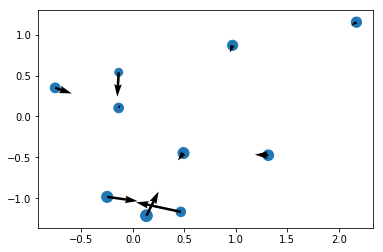

In [17]:
r, m = prep(10, numpy, seed = 17)
r[:, -1] = 0

ax, ay, az = accelerations(r, m).T
x, y, z = r.T

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x, y, m);
plt.quiver(x, y, ax, ay);

Looks just about right! The system is evidently self-gravitating. Let's do the same for a few more bodies:

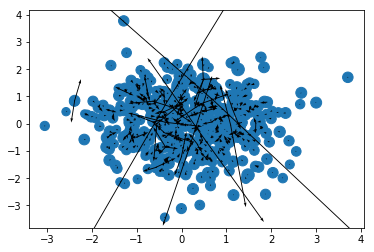

In [20]:
r, m = prep(500, numpy, seed = 17)
r[:, -1] = 0

ax, ay, az = accelerations(r, m).T
x, y, z = r.T

plt.scatter(x, y, m);
plt.quiver(x, y, ax, ay);

And that's a proper mess, but the arrows seem to be oriented the right way (towards the system's center of mass) and you get a bunch of very long arrows, signifying high forces at short distances - another issue that I might well come back to in another post!

And the nice thing is that our function works just as well on the GPU!

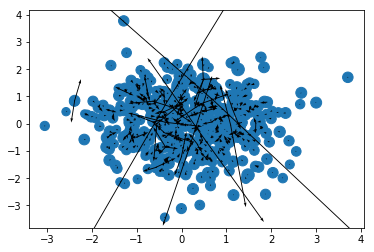

In [22]:
ax, ay, az = cupy.asnumpy(accelerations(cupy.asarray(r), cupy.asarray(m)).T)

plt.scatter(x, y, m);
plt.quiver(x, y, ax, ay);

Let's now run a quick bechmark:

In [23]:
results = []
numbers_of_bodies = [2**n for n in range(4, 13)]
for np in [numpy, cupy]:
    for N in numbers_of_bodies:
        r, m = prep(N, np, seed=17)
        time = %timeit -oq accelerations(r, m)
        results.append({"library":np.__name__,
                        "N": N,
                        "average": time.average,
                        "stdev": time.stdev})

In [24]:
import pandas

df = pandas.DataFrame(results)
df

N   average library     stdev
0     16  0.000076   numpy  0.000003
1     32  0.000179   numpy  0.000002
2     64  0.000589   numpy  0.000020
3    128  0.002245   numpy  0.000139
4    256  0.012159   numpy  0.003883
5    512  0.044007   numpy  0.004827
6   1024  0.187316   numpy  0.007669
7   2048  0.718909   numpy  0.027526
8   4096  2.867943   numpy  0.055799
9     16  0.001288    cupy  0.000021
10    32  0.001316    cupy  0.000030
11    64  0.001463    cupy  0.000146
12   128  0.001430    cupy  0.000112
13   256  0.001321    cupy  0.000024
14   512  0.001656    cupy  0.000022
15  1024  0.005480    cupy  0.000082
16  2048  0.020252    cupy  0.000017
17  4096  0.080994    cupy  0.000289

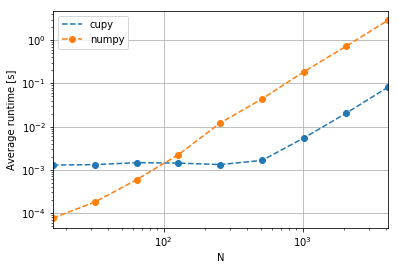

In [25]:
fig, ax = plt.subplots()
ax.set_ylabel("Average runtime [s]")
for label, g in df.groupby('library'):
    g.plot('N', 'average', ax=ax, label=label, logx=True, logy=True, style="o--")
ax.grid()

Thus at low numbers of particles, CuPy has a performance overhead, but at larger numbers of particles (as limited by `MemoryError`s on my device, with the regime shifting around 100 particles), the GPU (predictably) wins!

We can also calculate the runtime ratios for a speedup estimate:

In [26]:
speedups = df[df.library =='numpy'].set_index('N').average / df[df.library =='cupy'].set_index('N').average
speedups

N
16       0.059079
32       0.135752
64       0.402321
128      1.570570
256      9.204320
512     26.570801
1024    34.179128
2048    35.498837
4096    35.409139
Name: average, dtype: float64

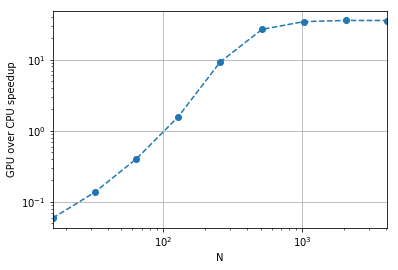

In [27]:
speedups.plot(logx=True, style="o--", logy=True)
plt.ylabel("GPU over CPU speedup");
plt.grid()

While this is obviously not a full proper test (we don't know how much host-device memory transfer would impact our timings, etc), it's at least nice to see that we get 35 times the speed on the GPU for the pure acceleration stage basically for free!